In [1]:
import openpyxl
import tensorflow as tf
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

In [2]:
tf.set_random_seed(777)

In [3]:
def min_max_scaling(x):
    numerator = x - np.min(x, 0)
    denominator = np.max(x, 0) - np.min(x, 0)
    return np.asarray(numerator / (denominator + 1e-7))
    
def reverse_min_max_scaling(data, x):
    max=np.max(data,0)
    min=np.min(data,0)
    return (x*(max[5]-min[5]+1e-7))+min[5]

In [4]:
input_data_column_cnt=6
output_data_column_cnt=1

seq_length=7
rnn_cell_hidden_dim=5
forget_bias=1.0
num_stacked_layers=1
keep_prob=1.0
final_test=3862

epoch_num=1800
learning_rate=0.01

In [5]:
#엑셀에서 데이터 가져오기
wb=openpyxl.load_workbook('timedata.xlsx')
ws=wb.active
data=[]
for r in ws.rows:
    data.append([r[1].value,r[2].value,r[3].value,r[4].value,r[5].value,r[6].value])
print(len(data))
print(data[0],data[1])

88681
[19.6, 0, 4.7, 230, 12, 52] [18.8, 0, 4.8, 270, 22, 58]


In [6]:
norm_data = min_max_scaling(data)

print("norm_data shape: ",norm_data.shape)
print("data[0]: ",data[0])
print("norm_data[0]: ",norm_data[0])
print("="*100)

x=norm_data
y=norm_data[:,[-1]]

print("x shape: ",x.shape)
print("x[0]: ",x[0])
print("="*100)
print("y shape: ",y.shape)
print("y[0]: ",y[0])

norm_data shape:  (88681, 6)
data[0]:  [19.6, 0, 4.7, 230, 12, 52]
norm_data[0]:  [0.69117647 0.         0.4122807  0.63888889 0.12       0.04205214]
x shape:  (88681, 6)
x[0]:  [0.69117647 0.         0.4122807  0.63888889 0.12       0.04205214]
y shape:  (88681, 1)
y[0]:  [0.04205214]


In [7]:
dataX=[]
dataY=[]

for i in range(0, len(y)-seq_length-final_test):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    if i is 0:
        print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

[[0.69117647 0.         0.4122807  0.63888889 0.12       0.04205214]
 [0.67647059 0.         0.42105263 0.75       0.22       0.0470984 ]
 [0.67279412 0.         0.37719298 0.75       0.26       0.06139613]
 [0.6617647  0.         0.38596491 0.63888889 0.31       0.06812447]
 [0.63235294 0.         0.30701754 0.75       0.33       0.07317073]
 [0.61029412 0.         0.35087719 0.75       0.36       0.06307822]
 [0.59007353 0.         0.20175438 0.80555556 0.38       0.07148865]] -> [0.06980656]


In [8]:
train_size=int(len(dataY)*0.7)
test_size=len(dataY)-train_size

trainX=np.array(dataX[0:train_size])
trainY=np.array(dataY[0:train_size])

testX=np.array(dataX[train_size:len(dataX)])
testY=np.array(dataY[train_size:len(dataY)])

print("trainX[0]: ",trainX[0])
print("trainY[0]: ",trainY[0])

print("trainX size: ",len(trainX))

trainX[0]:  [[0.69117647 0.         0.4122807  0.63888889 0.12       0.04205214]
 [0.67647059 0.         0.42105263 0.75       0.22       0.0470984 ]
 [0.67279412 0.         0.37719298 0.75       0.26       0.06139613]
 [0.6617647  0.         0.38596491 0.63888889 0.31       0.06812447]
 [0.63235294 0.         0.30701754 0.75       0.33       0.07317073]
 [0.61029412 0.         0.35087719 0.75       0.36       0.06307822]
 [0.59007353 0.         0.20175438 0.80555556 0.38       0.07148865]]
trainY[0]:  [0.06980656]
trainX size:  59368


In [9]:
X=tf.placeholder(tf.float32,[None,seq_length,input_data_column_cnt])
print("X: ",X)
Y=tf.placeholder(tf.float32,[None,1])
print("Y: ",Y)

targets=tf.placeholder(tf.float32,[None,1])
print("targets: ",targets)
predictions=tf.placeholder(tf.float32,[None,1])
print("predictions: ",predictions)

X:  Tensor("Placeholder:0", shape=(?, 7, 6), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [10]:
def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell
 
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()
 
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

hypothesis=tf.contrib.layers.fully_connected(hypothesis[:,-1],output_data_column_cnt, activation_fn=tf.identity)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 7, 5), dtype=float32)


In [11]:
loss=tf.reduce_sum(tf.square(hypothesis - Y))
    
optimizer=tf.train.AdamOptimizer(learning_rate)
    
train=optimizer.minimize(loss)
    
rmse=tf.sqrt(tf.reduce_mean(tf.squared_difference(targets,predictions)))

In [12]:
train_error_summary = [] # train data 오류율
test_error_summary = []  # validation data 오류율
test_predict = ''        # validation data 결과 기록
 
sess = tf.Session()
sess.run(tf.global_variables_initializer())
 
# 학습한다
start_time = datetime.datetime.now()
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째 or 마지막 epoch
        # train data
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # validation
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
print('학습이 끝났습니다...')

end_time = datetime.datetime.now() # 종료시간
elapsed_time = end_time - start_time
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

학습을 시작합니다...
epoch: 100, train_error(A): 0.019583547487854958, test_error(B): 0.020103350281715393, B-A: 0.0005198027938604355
epoch: 200, train_error(A): 0.01405928935855627, test_error(B): 0.013038544915616512, B-A: -0.0010207444429397583
epoch: 300, train_error(A): 0.012609758414328098, test_error(B): 0.011138862930238247, B-A: -0.0014708954840898514
epoch: 400, train_error(A): 0.011489839293062687, test_error(B): 0.009897232055664062, B-A: -0.0015926072373986244
epoch: 500, train_error(A): 0.01066692266613245, test_error(B): 0.00905677955597639, B-A: -0.0016101431101560593
epoch: 600, train_error(A): 0.010139402002096176, test_error(B): 0.008528366684913635, B-A: -0.001611035317182541
epoch: 700, train_error(A): 0.00984856579452753, test_error(B): 0.008227906189858913, B-A: -0.0016206596046686172
epoch: 800, train_error(A): 0.009697778150439262, test_error(B): 0.0080665098503232, B-A: -0.0016312683001160622
epoch: 900, train_error(A): 0.009604288265109062, test_error(B): 0.00796641

In [13]:
# hyperparameter
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')
 
print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')
 
print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')
 
print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))

input_data_column_cnt: 6,output_data_column_cnt: 1,seq_length: 7,rnn_cell_hidden_dim: 5,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 1.0,epoch_num: 1800,learning_rate: 0.01,train_error: 0.009212953,test_error: 0.007734119,min_test_error: 0.007733313


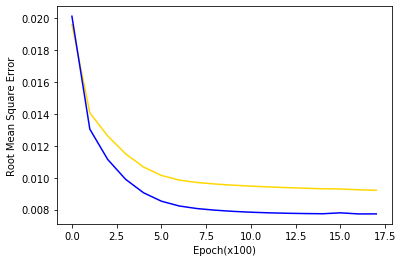

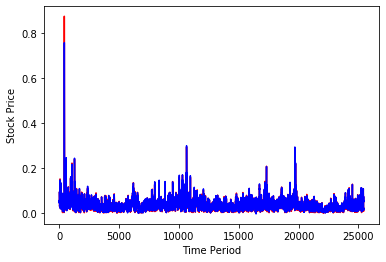

In [14]:
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')
 
plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()

In [15]:
testdataX=[]
testdataY=[]

for i in range(len(x)-final_test-seq_length,len(x)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    if i is 0:
        print(_x,"->",_y)
    testdataX.append(_x)
    testdataY.append(_y)
    
print("size of testdataX: ",len(testdataX))

size of testdataX:  3862


In [16]:
start_time = datetime.datetime.now()
print('결과값을 구하기 시작합니다...')

sum=0.0
result=[]
for i in range(0,len(testdataX)):
    if ((i+1) % 500 == 0) or (epoch == len(testdataX)-1):
        print("{}번째 계산중...".format(i+1))
    lastX=np.array([testdataX[i]])
    lastPredict=sess.run(hypothesis, feed_dict={X: lastX})
    lastPredict=reverse_min_max_scaling(data,lastPredict)

    result.append(lastPredict[0,0])

print("result size: ",len(result))

print('결과값을 모두 구했습니다...')
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

결과값을 구하기 시작합니다...
500번째 계산중...
1000번째 계산중...
1500번째 계산중...
2000번째 계산중...
2500번째 계산중...
3000번째 계산중...
3500번째 계산중...
result size:  3862
결과값을 모두 구했습니다...
elapsed_time: 0:12:03.968877
elapsed_time per epoch: 0:00:00.402205


In [17]:
wr=openpyxl.load_workbook('score.xlsx')
wrr=wr.active

for i in range(0,len(testdataX)):
    wrr.cell(row=i+1,column=1).value=result[i]
    
wr.save('score.xlsx')
wr.close()